# DATASCI 420AB - Course Project
### Zach Gongaware

## April 26 - Project Outline
### Project Goal

The goal of this project is to project what round (1 - 7, or undrafted) a given college football player might be selected in the NFL Draft.

### Data Sources

Credit to Sean J Taylor and his Learning the Draft project for original collection of data. There are three data sources for this project:

- college_stats.csv - Collegiate stats of players, drafted and undrafted
- combines.csv - Stats from yearly NFL Combine
- drafts.csv - Players drafted from years 2000 to 2015

### Methodology

This is primarily a classification problem, so either a decision tree or random forest is likely to be the most performant.

### Processing Steps (Pseudo-Code)
1. Data Source Collection and Preparation
   1. Load Draft data
       1. Create key field based on columns common to all three datasets
   2. Load Combine data
       1. Drop duplicate entries, create key fields, and create flag field noting combine participation
   3. Load College Stats data
       1. Create key field, roll up duplicate metrics
       2. Pivot to wide format table
       3. Fill NAs with 0
    4. Merge all three data sets based on the key field
        1. Combine equivalent columns
        2. Drop rows with missing position data
        3. Fill NAs 
2. Prepare data for modeling
   1. Convert height fields to inches
   2. Create position group field
   3. Impute missing combine stats based on mean score of each position group
   4. Classify colleges based on number of players
       1. Keep schools names for those with 2+ z-score
       2. Roll up to "Mid-Sized School" for those with z-score between 0 and 2
       3. Roll up to "Small School" for those with z-score below 0
   5. One-Hot Encode Categorical Fields
       1. Position
       2. College
   6. Drop columns extraneous columns
   7. Scale all features using z-score
3. Divide data into train and test sets
   1. Isolate target field (Round) from each set
4. Fit Model
   1. Fit model to train set
   2. Feed test set to generate predictions
5. Assess Model Performance
   1. Assess performance using confusion matrix and ROC chart
6. Repeat Steps 2 - 5 until satisfied with results.
   1. Adjust model parameters
   2. Remove or add features based on their impact on the model
   
## May 17 - Exploratory Data Analysis

In [336]:
# Load Scripting File
%run project_util.py

# Perform unit testing
perform_unit_tests()

# load each data set
draft = load_draft_data()
comb = load_combine_data()
stats = load_college_data()

### Draft Data

In [87]:
draft.shape

(4079, 10)

In [88]:
draft.head()

,year,round,pick,team,player,pos,age,college,url,key
0,2000,1,1,CLE,Courtney Brown,DE,22.0,Penn St.,http://www.sports-reference.com/cfb/players/co...,http://www.sports-reference.com/cfb/players/co...
1,2000,1,2,WAS,LaVar Arrington,LB,22.0,Penn St.,http://www.sports-reference.com/cfb/players/la...,http://www.sports-reference.com/cfb/players/la...
2,2000,1,3,WAS,Chris Samuels,T,23.0,Alabama,http://www.sports-reference.com/cfb/players/ch...,http://www.sports-reference.com/cfb/players/ch...
3,2000,1,4,CIN,Peter Warrick,WR,23.0,Florida St.,http://www.sports-reference.com/cfb/players/pe...,http://www.sports-reference.com/cfb/players/pe...
4,2000,1,5,BAL,Jamal Lewis,RB,21.0,Tennessee,http://www.sports-reference.com/cfb/players/ja...,http://www.sports-reference.com/cfb/players/ja...


Key field is derived from URL; or player name + year if URL is missing.

In [89]:
draft.dtypes

year         int64
round        int64
pick         int64
team        object
player      object
pos         object
age        float64
college     object
url         object
key         object
dtype: object

Position and college will have to be one-hot encoded to be factored into the model.  Year, Pick, Team, and Player Name will need to be excluded to prevent over-fitting.

In [90]:
draft.isnull().sum()

year          0
round         0
pick          0
team          0
player        0
pos           0
age         276
college      10
url        1087
key           0
dtype: int64

Around 1/4 of entries do not have URL and some are missing age.
### Combine Data

In [91]:
comb.shape

(5552, 15)

In [92]:
comb.head()

,year_combine,player_combine,pos_combine,college_combine,height,weight,forty,vertical,bench,broad,threecone,shuttle,url_combine,key,combine_participant
0,2000,John Abraham,OLB,South Carolina,6-4,252,4.55,NaN,NaN,NaN,NaN,NaN,NaN,John Abraham-2000,1
1,2000,Shaun Alexander,RB,Alabama,6-0,218,4.58,NaN,NaN,NaN,NaN,NaN,http://www.sports-reference.com/cfb/players/sh...,http://www.sports-reference.com/cfb/players/sh...,1
2,2000,Darnell Alford,OT,Boston College,6-4,334,5.56,25.0,23.0,94.0,8.48,4.98,NaN,Darnell Alford-2000,1
3,2000,Kyle Allamon,TE,Texas Tech,6-2,253,4.97,29.0,NaN,104.0,7.29,4.49,NaN,Kyle Allamon-2000,1
4,2000,Rashard Anderson,CB,Jackson State,6-2,206,4.55,34.0,NaN,123.0,7.18,4.15,NaN,Rashard Anderson-2000,1


Dimensions that match those in draft data set labeled with _combine

In [93]:
comb.dtypes

year_combine             int64
player_combine          object
pos_combine             object
college_combine         object
height                  object
weight                   int64
forty                  float64
vertical               float64
bench                  float64
broad                  float64
threecone              float64
shuttle                float64
url_combine             object
key                     object
combine_participant      int64
dtype: object

Height field will need to be converted to measurable integer.

In [94]:
comb.isnull().sum()

year_combine              0
player_combine            0
pos_combine               0
college_combine           0
height                    0
weight                    0
forty                   112
vertical               1338
bench                  1836
broad                  1591
threecone              1952
shuttle                1916
url_combine            1298
key                       0
combine_participant       0
dtype: int64

A lot of missing data in field tests from players who were injured or chose not to participate.
### College Stats Data

In [95]:
stats.shape

(4488, 58)

In [96]:
stats.head()

metric,key,adj_yards_per_attempt,ast_tackles,attempts,comp_pct,completions,fum_forced,fum_rec,fum_tds,fum_yds,...,td_fr,td_int,td_kr,td_pr,td_rec,td_rush,td_tot,total_pts,twopm,yards_per_attempt
0,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.0,20.0,26.0,156.0,0.0,0.0
2,http://www.sports-reference.com/cfb/players/aa...,0.0,65.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0
3,http://www.sports-reference.com/cfb/players/aa...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,10.0,60.0,0.0,0.0
4,http://www.sports-reference.com/cfb/players/aa...,0.0,64.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data was pivoted to one row per key entry to match other sets.  Missing data filled in with 0s.

In [98]:
stats.dtypes.value_counts()

float64    57
object      1
dtype: int64

In [99]:
stats.isnull().sum().sum()

0

Null values take care of in loading function. (*see project_util.py*)

### Combined Data Set

In [337]:
combined = combine_data_sets(draft, comb, stats)

In [334]:
combined.shape

(5556, 75)

In [338]:
combined.head()

,year,round,pick,team,player,pos,age,college,key,height,...,td_fr,td_int,td_kr,td_pr,td_rec,td_rush,td_tot,total_pts,twopm,yards_per_attempt
0,2000.0,1,1.0,CLE,Courtney Brown,DE,22.0,Penn St.,http://www.sports-reference.com/cfb/players/co...,6-5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0
1,2000.0,1,2.0,WAS,LaVar Arrington,LB,22.0,Penn St.,http://www.sports-reference.com/cfb/players/la...,6-3,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0
2,2000.0,1,3.0,WAS,Chris Samuels,T,23.0,Alabama,http://www.sports-reference.com/cfb/players/ch...,6-5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000.0,1,4.0,CIN,Peter Warrick,WR,23.0,Florida St.,http://www.sports-reference.com/cfb/players/pe...,5-11,...,0.0,0.0,0.0,2.0,32.0,4.0,38.0,228.0,0.0,26.7
4,2000.0,1,5.0,BAL,Jamal Lewis,RB,21.0,Tennessee,http://www.sports-reference.com/cfb/players/ja...,6-0,...,0.0,0.0,0.0,0.0,4.0,17.0,21.0,126.0,0.0,10.0


In [331]:
combined.dtypes.value_counts()

float64    70
object      6
dtype: int64

Six remaining categorical fields to either encode or remove.

In [104]:
combined.isnull().sum()

year                        0
round                       0
pick                        0
team                        0
player                      0
pos                         0
age                      1753
college                     0
key                         0
height                    774
weight                    774
forty                     821
vertical                 1893
bench                    2378
broad                    1919
threecone                2429
shuttle                  2394
combine_participant         0
adj_yards_per_attempt       0
ast_tackles                 0
attempts                    0
comp_pct                    0
completions                 0
fum_forced                  0
fum_rec                     0
fum_tds                     0
fum_yds                     0
games                       0
int                         0
int_rate                    0
                         ... 
punt_return_td              0
punt_return_yards           0
punt_retur

Missing combine data to be imputed based on positional group.

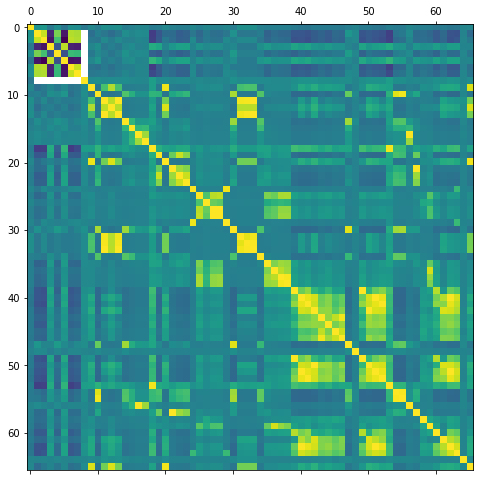

In [105]:
# Assess correlation
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(8,8))
_ = plt.matshow(combined.drop(['year','round','pick'],axis=1).corr(), fignum=1)
plt.show()

There appears to be several pockets of highly correlated dimensions.

In [107]:
c = combined.drop(['year','round','pick'],axis=1).corr().abs()
c = c.unstack().to_frame()

c.index = ['-'.join(col).strip() for col in c.index.values]
c = c.rename(columns={0:'corr'})

c[c['corr'] < 1.0].sort_values(by='corr', ascending=False).head(10)

,corr
completions-attempts,0.996953
attempts-completions,0.996953
scrim_plays-receptions,0.996791
receptions-scrim_plays,0.996791
pass_yards-completions,0.995823
completions-pass_yards,0.995823
pass_yards-attempts,0.995590
attempts-pass_yards,0.995590
kick_returns-kick_return_yards,0.995334
kick_return_yards-kick_returns,0.995334


There are several highly correlated fields around game stats, particularly those that relate as "attempts" and "successes".  Converting attempts to a success rate field may be helpful.

## CHECKPOINT - Modeling

In [246]:
%run project_util.py
perform_unit_tests()
draft = load_draft_data()
comb = load_combine_data()
stats = load_college_data()
combined = combine_data_sets(draft, comb, stats)
combined = engineer_features(combined)

In [247]:
X_train, y_train, X_test, y_test = perform_modeling_prep(combined, 'round')

rf_clf, rf_y_predict, rf_accuracy = perform_random_forest(X_train, y_train, X_test, y_test)
print('Random Forest: {}'.format(rf_accuracy))

Random Forest: 0.4025706940874036


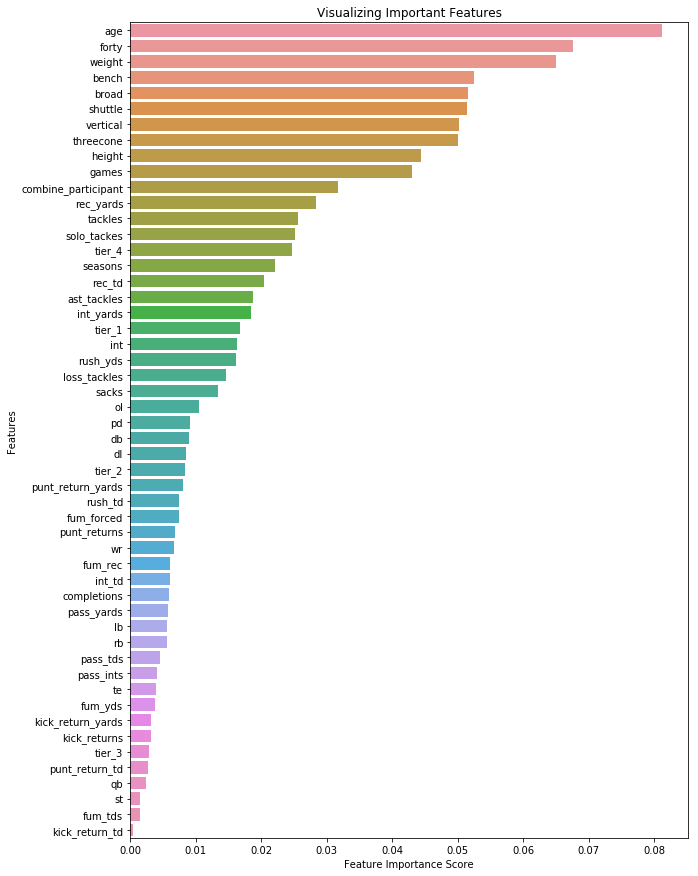

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.Series(rf_clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
_ = plt.figure(figsize=(10,15))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Alternative Approach - Drafted / Undrafted

In [155]:
combined['drafted'] = combined['round'].apply(lambda x: 0 if x == 8 else 1)
combined.drop(['round'], axis=1, inplace=True)
X_train, y_train, X_test, y_test = perform_modeling_prep(combined, 'drafted')

rf_clf, rf_y_predict, rf_accuracy = perform_random_forest(X_train, y_train, X_test, y_test)
print('Random Forest: {}'.format(rf_accuracy))

Random Forest: 0.9372750642673522


## Testing Stuff

In [77]:
c_cols = ['age', 'height', 'weight', 'forty', 'vertical', 'broad', 'bench', 'threecone', 'shuttle']

# for col in c_cols:
#     drop_cols = [x for x in c_cols if x != col]
#     print(use_cols)

drop_cols = [x for x in c_cols if x != 'forty']
drop_cols.append('round')

comb_test = combined.dropna(axis=0, how='any').drop(drop_cols, axis=1)

X_train, y_train, X_test, y_test = perform_modeling_prep(comb_test, 'age')

In [156]:
# Modeling Wrapper Function
def perform_modeling(target):
    # Load and prep data
    %run project_util.py
    perform_unit_tests()
    draft = load_draft_data()
    comb = load_combine_data()
    stats = load_college_data()
    combined = combine_data_sets(draft, comb, stats)
    combined = engineer_features(combined)

    # Define target column
    target_col = 'r{}'.format(target)

    # Populate column and drop round feature
    combined[target_col] = combined['round'].astype(int).apply(lambda x: 1 if x == target else 0)
    combined.drop(['round'], axis=1, inplace=True)

    # Train / Test Split
    X_train, y_train, X_test, y_test = perform_modeling_prep(combined, target_col)

    # Perform Random Forest
    rf_clf, rf_y_predict, rf_accuracy = perform_random_forest(X_train, y_train, X_test, y_test)
    
    d = {'target': target, 'model': 'rf', 'clf': rf_clf, 'predictions': rf_y_predict, 'accuracy': rf_accuracy}

    # Perform SVM
#     svm_clf, svm_y_predict, svm_accuracy = perform_svm(X_train, y_train, X_test, y_test)

#     d = {'target': target, 'model': 'svm', 'clf': svm_clf, 'predictions': svm_y_predict, 'accuracy': svm_accuracy}
    
    return d


In [157]:
# Generate predictions on each round
targets = [1, 2, 3, 4, 5, 6, 7, 8]
results = []

for t in targets:
    results.append(perform_modeling(t))

In [302]:
def pred_to_round(x):
    preds = [i if i == 0 else x['target'] for i in x['predictions']]

    return list(preds)

In [352]:
for result in results:
    print(result['target'])
    for x in result['predictions']:
        if x == 1:
            result['predictions'][x] = result['target']

1
2
3
4
5
6
7
8


In [347]:
target_col = 'R1'
target = 1

combined[target_col] = combined['round'].astype(int).apply(lambda x: 1 if x == target else 0)
#combined.drop(['round'], axis=1, inplace=True)

combined[target_col].value_counts()

0    5047
1     509
Name: R1, dtype: int64